In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re



# EDA

In [2]:
# load data
df = pd.read_csv("../data/initial_data/frmgham2.csv")

features = list(df.columns.copy())
features.remove("STROKE")
df = df[features + ['STROKE']]

print(df.shape)

(11627, 39)


In [24]:
unique_values = df.nunique().to_frame().reset_index().rename(columns={"index":"Feature",0:"UniqueValues"})
unique_values.sort_values("UniqueValues",inplace=True)

cat_cols = unique_values[(unique_values['UniqueValues'] < 5) & (unique_values['Feature'] != 'CVD')].shape[0]
num_cols = unique_values[unique_values['UniqueValues'] > 5].shape[0]

print(f"Number of Categorical Features: {cat_cols}\nNumber of Numerical Features: {num_cols} \n\n")
unique_values

Number of Categorical Features: 18
Number of Numerical Features: 20 




,Feature,UniqueValues
38,STROKE,2
25,HOSPMI,2
24,ANGINA,2
23,DEATH,2
28,CVD,2
18,PREVHYP,2
17,PREVSTRK,2
16,PREVMI,2
15,PREVAP,2
14,PREVCHD,2


In [4]:
categorical_features = unique_values[unique_values['UniqueValues']<5]['Feature'].values.tolist()
try:
    categorical_features.remove("DEATH")
except:
    pass
numerica_features = unique_values[unique_values['UniqueValues']>5]['Feature'].values.tolist()


In [5]:
feature_dict = {"categorical": categorical_features,
                "numerical":numerica_features}

In [6]:
# n obs, n features
n_obs,n_features = df.shape
n_features = n_features-1

## Missing values

In [7]:
# count missing values for each column
missings = df.isna().sum().to_frame().reset_index().rename(columns={"index":"Feature",0:"Counts"})
missings = missings[missings['Counts'] != 0]
missings['Percent'] = missings['Counts'] / n_obs
missings.sort_values("Counts",inplace=True)

n_missings = missings.shape[0]



print(F"{n_missings} out of {n_features} features have missings values!!")

9 out of 38 features have missings values!!


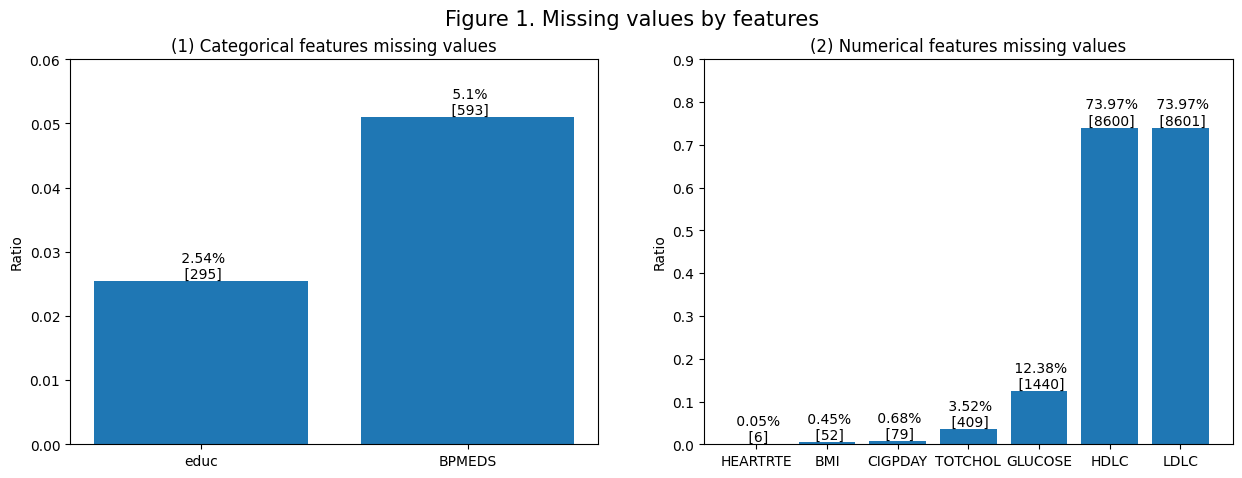

In [8]:
print()

fig,ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)


fig.suptitle("Figure 1. Missing values by features\n\n\n",fontsize=15)


for i,key in enumerate(feature_dict):

    fets = feature_dict[key]
    # print(fets)
    
    missings = df[fets].isna().sum().to_frame().reset_index().rename(columns={"index":"Feature",0:"Counts"})
    missings = missings[missings['Counts'] != 0]
    missings['Percent'] = missings['Counts'] / n_obs
    missings.sort_values("Counts",inplace=True)

        
    ax[i].bar(missings['Feature'],missings['Percent'])
    ax[i].set_title(f"({i+1}) {key.capitalize()} features missing values")

    if key == 'categorical':
        ax[i].set_ylim(0,0.06)
    else:
        ax[i].set_ylim(0,0.9)


    ax[i].set_ylabel("Ratio")
    
    # Annotate each bar with its value
    for index, value in enumerate(missings['Percent']):
        # print(value)
        miss_rate = value
        counts = missings['Counts'].values[index]
        annot = f" {str(round(miss_rate*100,2))}%\n [{str(counts)}]" 
        ax[i].text(index, value,  annot, ha='center', va='bottom')
        
    # plt.xticks(rotation=45)
    # plt.title("Figure 1. Percent of missing values")


plt.show()

print()


About 74% of **HDLC** and **LDLC** features values are missing, so, it is not reasonable to impute missing values for these attributes. It is better to just drop them from data set. The remaining features with low ratio of missing values we are going to fill.

In [9]:
columns_to_remove = missings[missings['Percent'] > .5]['Feature'].values
columns_to_remove

array(['HDLC', 'LDLC'], dtype=object)

In [10]:
# try:
#     df.drop(columns_to_remove,axis=1,inplace=True)
#     df.to_csv("../data/initial_data/frmgham2_project_data.csv",index=False)
# except:
#     print(f"Columns {columns_to_remove.tolist()} not found!")

## Imbalance labels

Zero outomce has more than twice occurance. We can fix this by oversampling or undersampling, or use imbalanced data, but use as much metrics as possible for model evaluation.

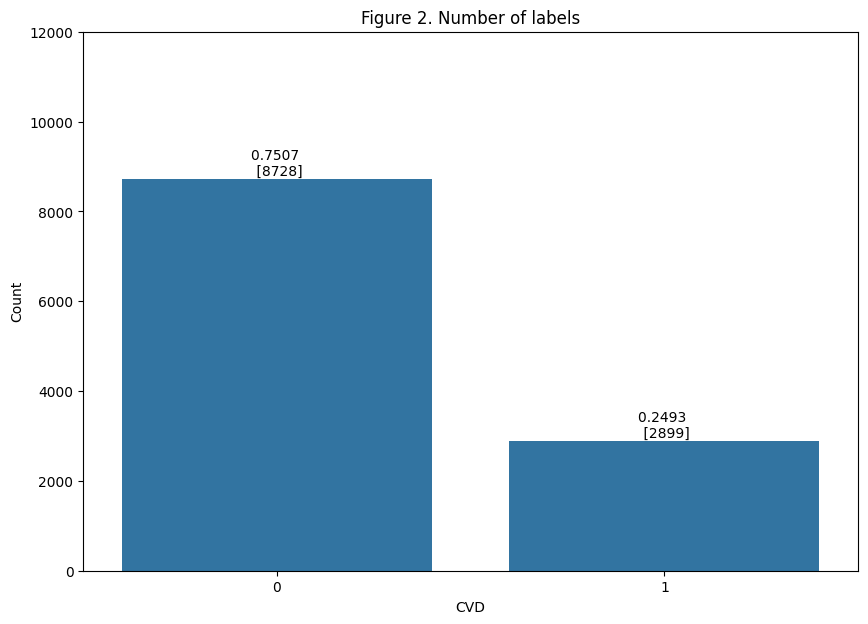

In [11]:


label_counts = df['CVD'].value_counts().to_frame().reset_index().rename(columns={"count":"Count"})
label_counts['Percent'] = label_counts['Count']/n_obs
plt.figure(figsize=(10,7))

sns.barplot(label_counts,x='CVD',y='Count')

for index, value in enumerate(label_counts['Percent']):
    
    miss_rate = value
    counts = label_counts['Count'].values[index]
    annot = f"{str(round(miss_rate,4))} \n [{str(counts)}]" 
    plt.text(index, counts,  annot, ha='center', va='bottom')

        
plt.ylim(0,12000)
plt.title("Figure 2. Number of labels")

plt.show()